# Guia 6

## Ejercicio 2

Diseñe e implemente un algoritmo genético que busque el mejor subconjunto de características para la clasificación de cáncer (leucemia linfocítica aguda y leucemia mielógena aguda) a partir de datos genómicos. Se proveen 38 muestras en el conjunto de entrenamiento y 34 en el conjunto de prueba (`leukemia_train.csv` y `leukemia_test.csv`, respectivamente). Cada muestra se compone de un total de 7129 características, que corresponden a valores de expresión génica.

### Solución

La solución buscada será una selección de características de entre las 7129 necesarias para que un perceptrón multicapa resuelva el problema, dando mayor aptitud a aquellas con menor número de características (promoviendo la simplicidad de la solución).
Para solución se **codificará** como una cadena de 7129 bits, donde un `1` indicará que la característica es necesaria para solución y un `0` que no.

> Esto que sigue es inchequeable, no lo probe

Para evaluar su aptitud se entrenará un perceptrón multicapa con esas características y los datos de entrenamiento y se medirá su precision. Finalmente, su aptitud estará dada por
$$
f =
\begin{cases}
    -1000 \quad&\text{si }N = 0\\
    \text{precision} - 0.01*N \quad&\text{en otro caso}
\end{cases}
$$
donde $N$ serán la cantidad de características de la solución.

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import os
import numpy as np
import matplotlib.pyplot as plt
from Evol import Evol

def cargarCSV(csvRelativePath, delimeter = ',') -> np.ndarray[any]:
    this_folder = os.path.abspath('') 
    fullPath = os.path.join(this_folder, csvRelativePath)
    return np.loadtxt(fullPath, dtype=float, delimiter=delimeter)

# ===== Leer archivos =====
# leer archivos
trnFileConcent = cargarCSV("C:\FICH\INTELIGENCIA COMPUTACIONAL\Guia6\leukemia_train.csv")
tstFileConcent = cargarCSV("C:\FICH\INTELIGENCIA COMPUTACIONAL\Guia6\leukemia_test.csv")

x_trn = trnFileConcent[:,:-1]
yd_trn = trnFileConcent[:,-1]
x_tst = tstFileConcent[:,:-1]
yd_tst = tstFileConcent[:,-1]

<>:17: SyntaxWarning: invalid escape sequence '\F'
<>:18: SyntaxWarning: invalid escape sequence '\F'
<>:17: SyntaxWarning: invalid escape sequence '\F'
<>:18: SyntaxWarning: invalid escape sequence '\F'
C:\Users\giuli\AppData\Local\Temp\ipykernel_19500\2332727586.py:17: SyntaxWarning: invalid escape sequence '\F'
  trnFileConcent = cargarCSV("C:\FICH\INTELIGENCIA COMPUTACIONAL\Guia6\leukemia_train.csv")
C:\Users\giuli\AppData\Local\Temp\ipykernel_19500\2332727586.py:18: SyntaxWarning: invalid escape sequence '\F'
  tstFileConcent = cargarCSV("C:\FICH\INTELIGENCIA COMPUTACIONAL\Guia6\leukemia_test.csv")


In [ ]:
# ===== Algoritmo evolutivo =====
# funcion de decodificacion
def b2caracts(x: np.ndarray[np.uint8]) -> list[np.ndarray[int]]|np.ndarray[int]:
    x = np.atleast_2d(x)
    # una poblacion
    N, B = x.shape  # N individuos, B bits por individuo
    caracts = [np.flatnonzero(x[i]) for i in range(N)] #indices de bits en 1 en cada individuo
    return caracts if len(caracts) > 1 else caracts[0]

# funcion de binarizacion
def f2b(x: list[float], B: int) -> np.ndarray[np.uint8]:
    x = np.atleast_1d(x)
    norm = x/1024 + 0.5
    ints = np.clip(np.round(norm * (2**B - 1)), 2**B - 1).astype(np.uint64)
    bits = ((ints[:, None] >> np.arange(B-1, -1, -1)) & 1).astype(np.uint8)
    return bits if len(x) > 1 else bits[0]

@ignore_warnings(category=ConvergenceWarning)
def fitness(x: np.ndarray[np.uint8]) -> np.ndarray[float]|float:
    # obtenemos los indices de las caracteristicas
    individuos = b2caracts(x)
    n_individuos = len(individuos)
    fits = np.zeros(n_individuos, dtype=float)
    for i, caracts in enumerate(individuos):
        n_caracts = caracts.shape[0]
        # si hay 0 caracteristicas, penalizar
        if n_caracts == 0:
            fits[i] = -1000
            continue

        # entrenamos y evaluamos el perceptron con las caracteristicas elegidas
        inputs = x_trn[:,caracts] #columnas correspondientes a las caracteristicas
        mlp = MLPClassifier(
            hidden_layer_sizes=(n_caracts), #tantas neuronas como caracteristicas
            max_iter=5
        )
        mlp.fit(inputs, yd_trn)
        acc = accuracy_score(yd_trn, mlp.predict(inputs))
        fits[i] = acc - 0.01 * n_caracts #función de fitness: accuracy - 0.01 * n_caracts

    return fits if fits.shape[0] > 1 else fits[0]

def init_poblacion(N: int, B: int, rng: np.random.Generator) -> np.ndarray[np.uint8]:
    # tomar 20 posiciones al azar y hacerlas 1 (para cada individuo)
    pob = np.zeros((N,B),dtype=np.uint8)
    posiciones = rng.integers(0,B,size=(N,20))
    for n in range(N):
        pob[n, posiciones[n,:]] = 1
    return pob

evol = Evol(
    init_fun=init_poblacion,
    fit_fun=fitness,
    max_gen=400,
    poblacion=200,
    progenitores=20,
    long_cromosoma=7129,
    mutacion=0.1,
    tolerancia=100
)

poblacion = evol.evolve()

 35%|███▌      | 140/400 [01:06<02:02,  2.11it/s]


In [4]:
mejor = poblacion[np.argmin(fitness(poblacion))]
mejores_caracteristicas = b2caracts(mejor)
mlp = MLPClassifier(
    hidden_layer_sizes=(mejores_caracteristicas.shape[0]),
    max_iter=500
)
mlp.fit(x_trn[:,mejores_caracteristicas], yd_trn)
acc_trn = accuracy_score(yd_trn, mlp.predict(x_trn[:,mejores_caracteristicas]))
acc_tst = accuracy_score(yd_tst, mlp.predict(x_tst[:,mejores_caracteristicas]))

cantidad de caracteristicas de la solucion: 12
acc en train: 0.7105263157894737
acc en test: 0.5882352941176471


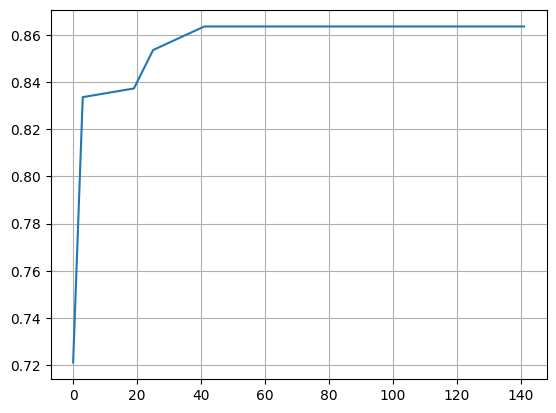

In [5]:
print(f"cantidad de caracteristicas de la solucion: {mejores_caracteristicas.shape[0]}")
print(f"acc en train: {acc_trn}")
print(f"acc en test: {acc_tst}")
plt.grid()
plt.plot(evol.fit_history[:,0],evol.fit_history[:,1]);